In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import os
from os import listdir
from os.path import isfile, join
from enum import Enum
%load_ext autoreload
%autoreload 2
from ExtractInfoFromGrid import show_single_training_example_visually, read_single_training_example
# from ExtractInfoFromGrid import *
# from DatasetVisualization import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


In [2]:
mypath = '../../ARC_Dataset/mini_training/OP_EQUAL_IP/NonColoredDataset'
onlyfiles_train = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles_train.sort()
print(f"Total files in mini training are {len(onlyfiles_train)}")

mypath = '../../ARC_Dataset/mini_testing/OP_EQUAL_IP/NonColoredDataset'
onlyfiles_test = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles_test.sort()
print(f"Total files in mini testing are {len(onlyfiles_test)}")

Total files in mini training are 59
Total files in mini testing are 43


Visualizing files in substitution category mini training
i = 4


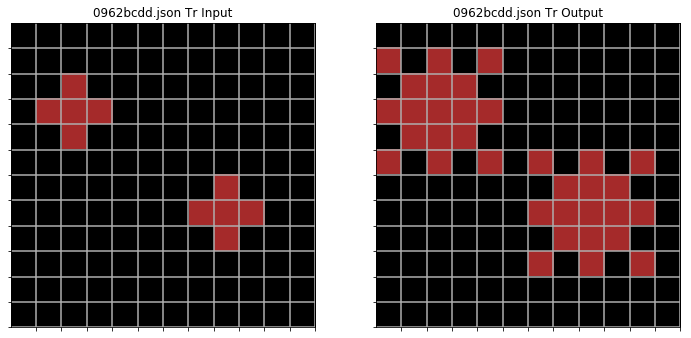

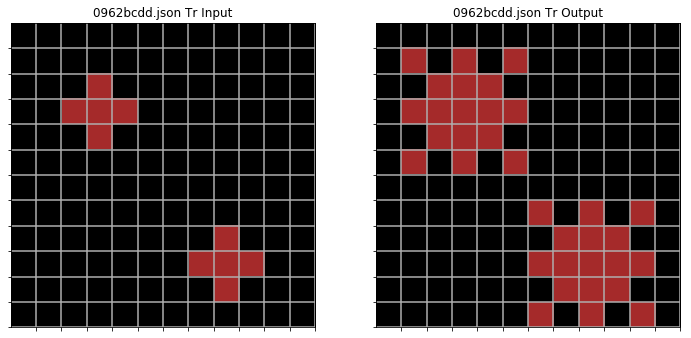

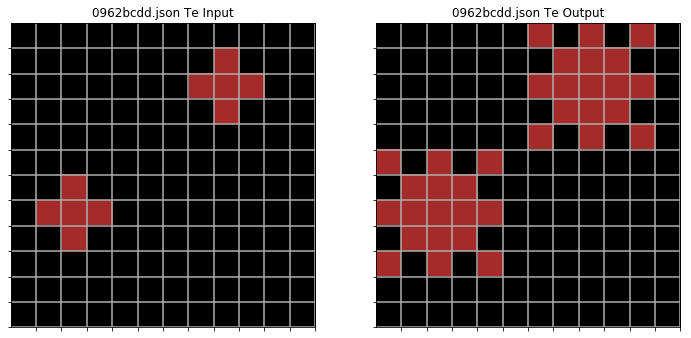

i = 19


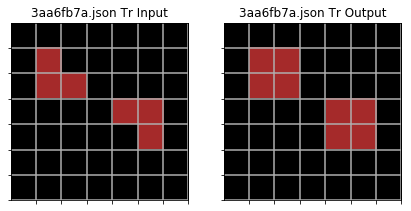

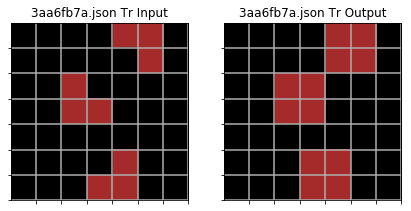

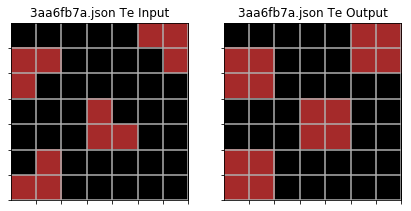

i = 20


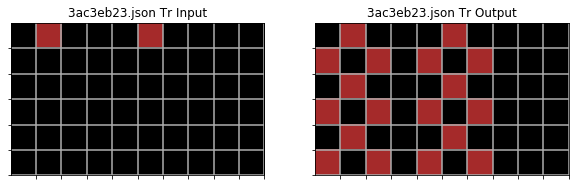

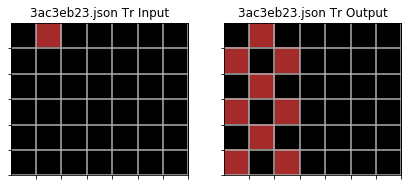

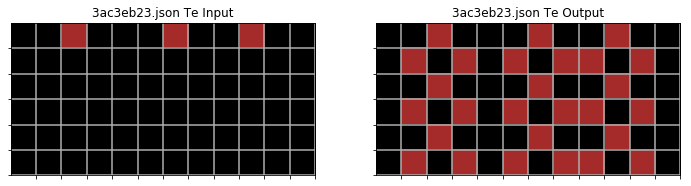

i = 21


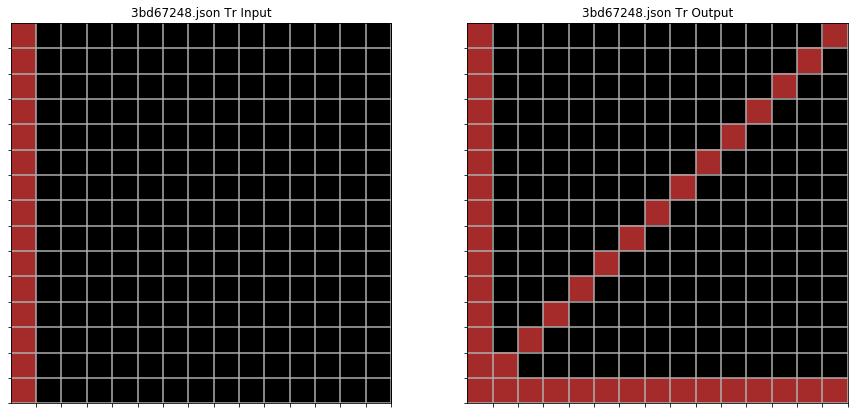

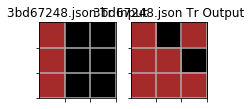

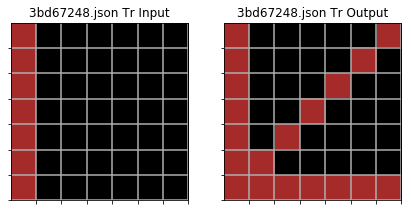

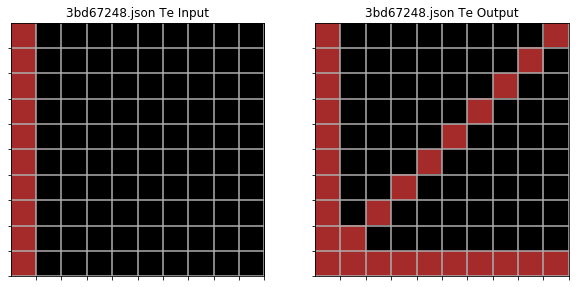

i = 22


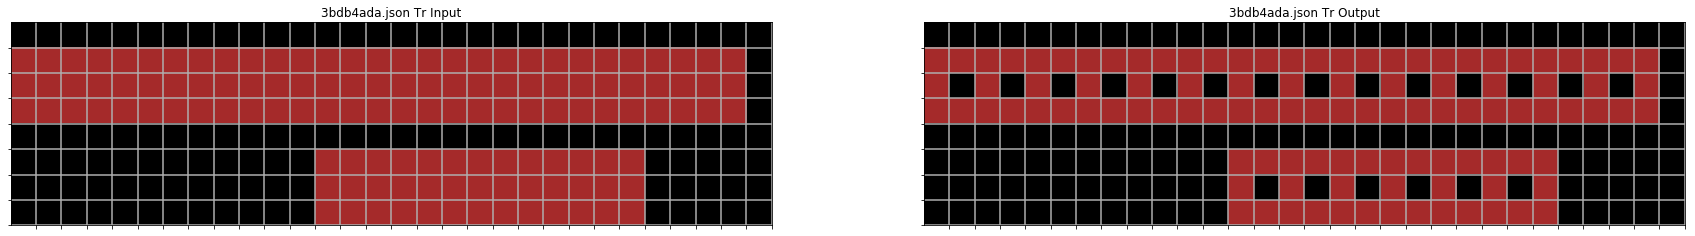

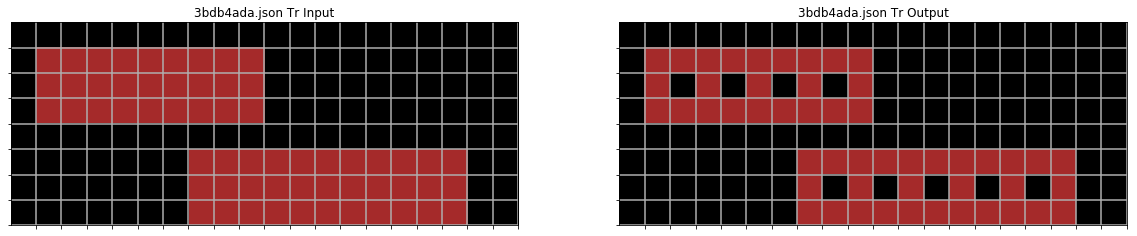

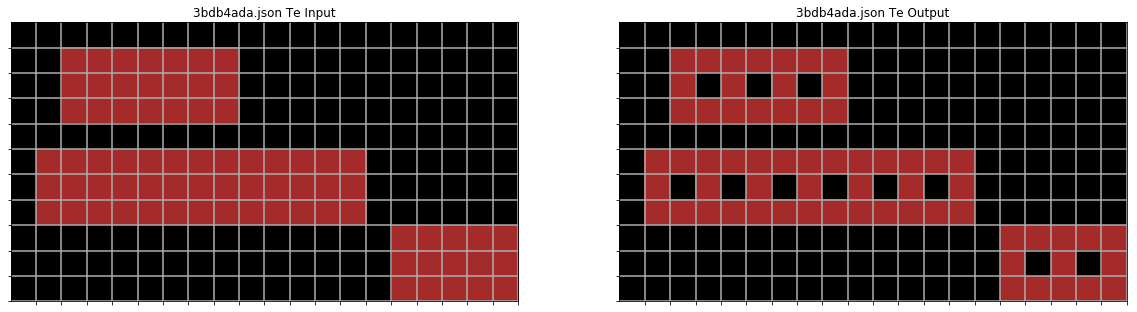

i = 23


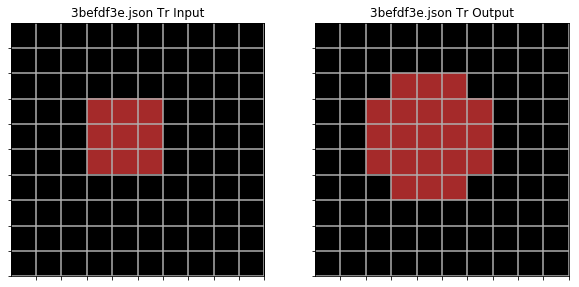

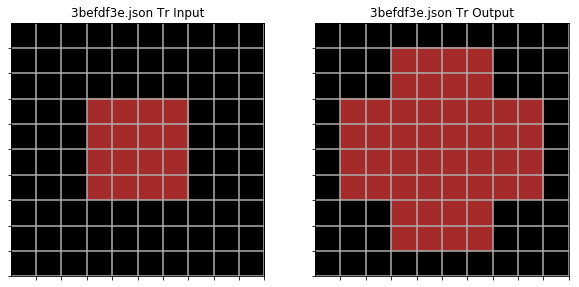

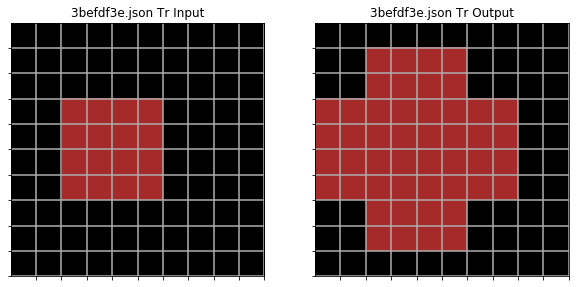

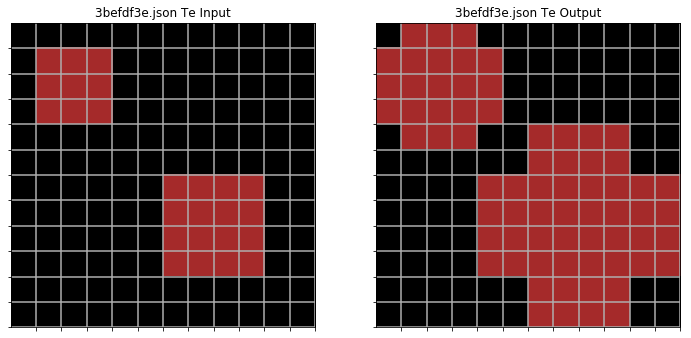

i = 25


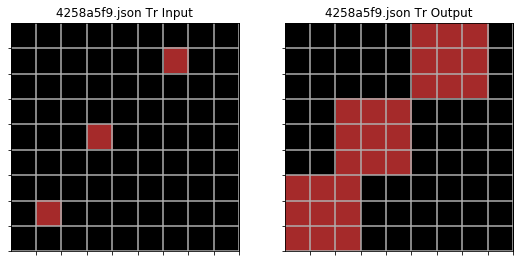

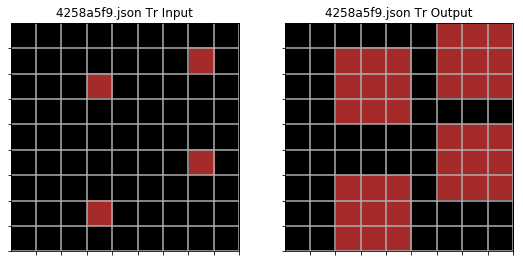

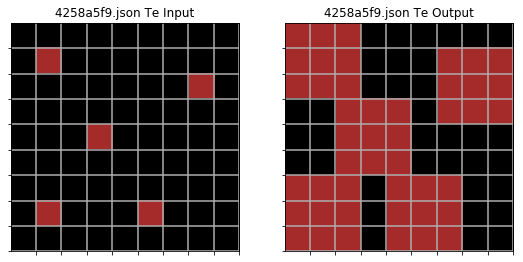

i = 26


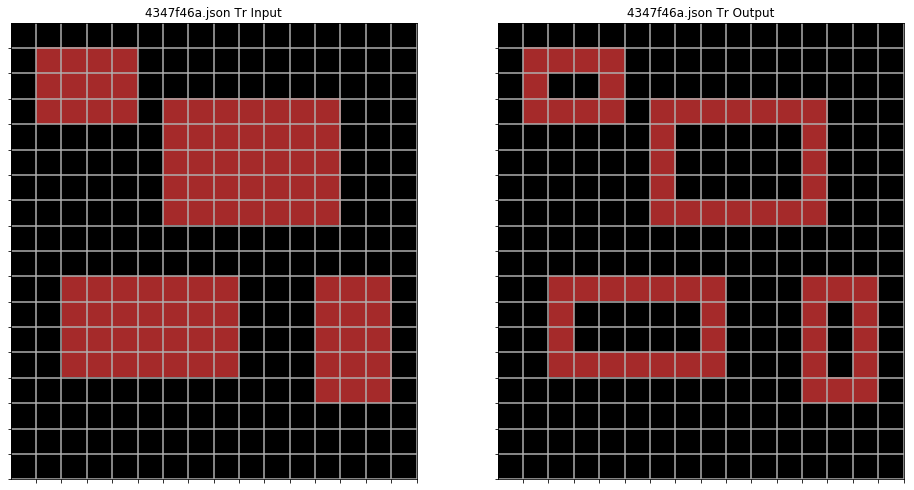

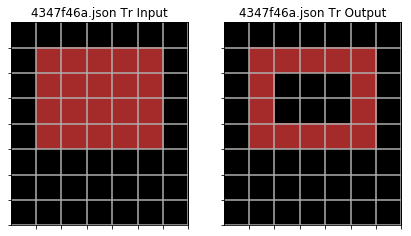

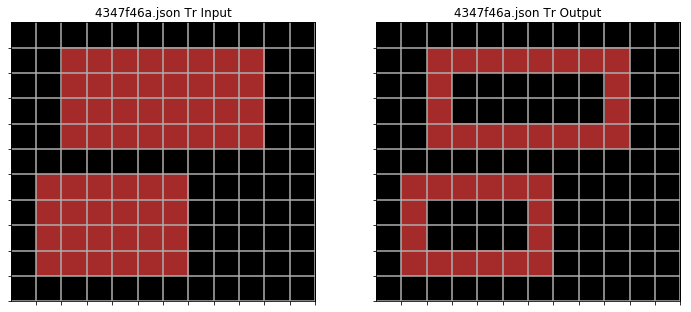

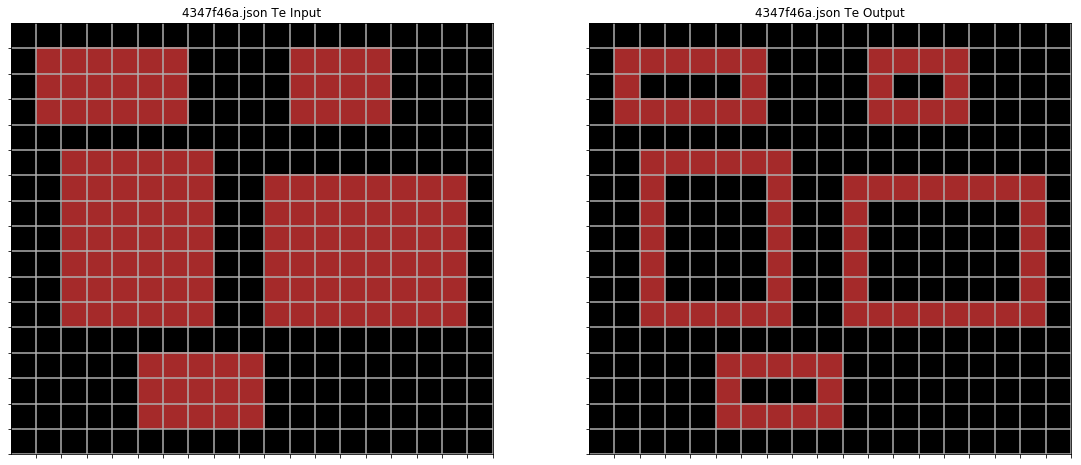

i = 33


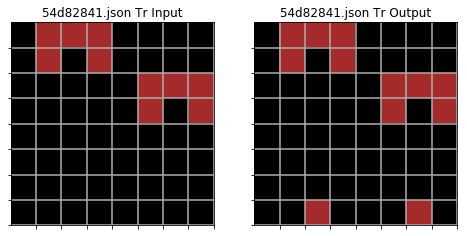

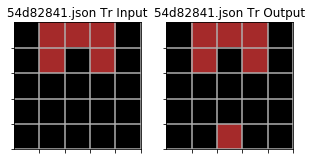

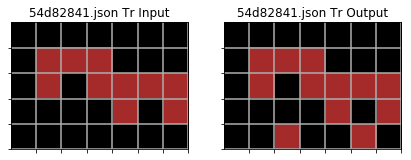

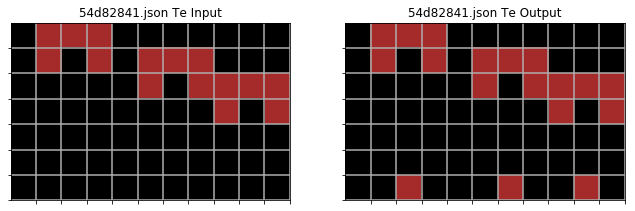

i = 36


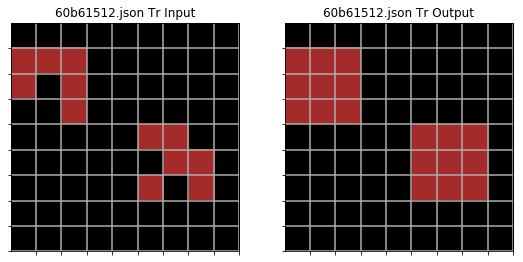

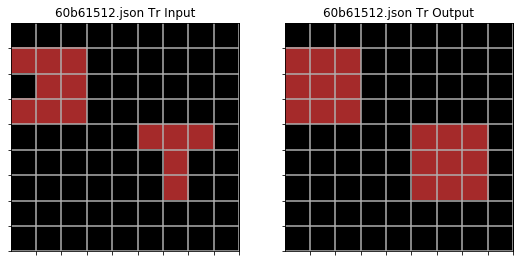

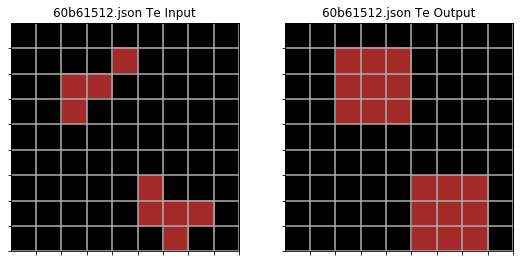

i = 39


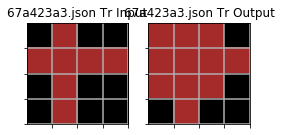

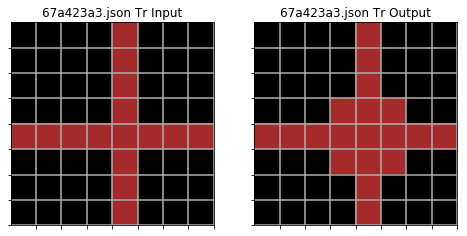

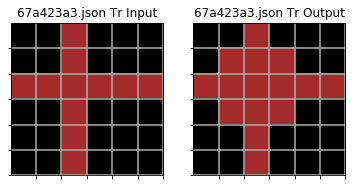

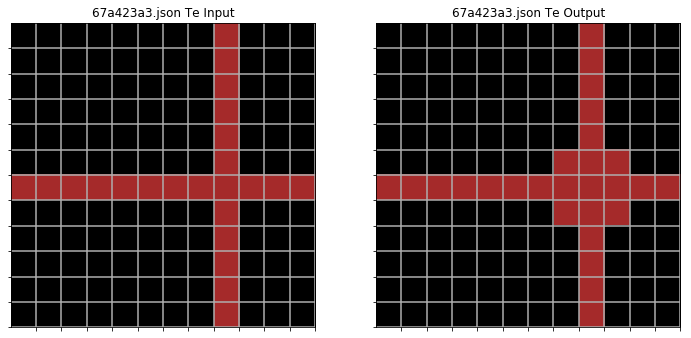

i = 40


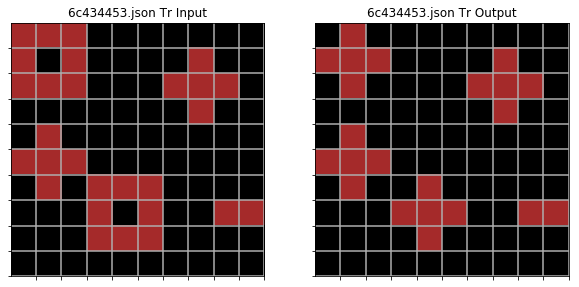

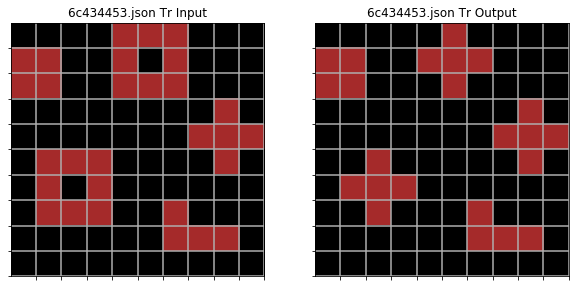

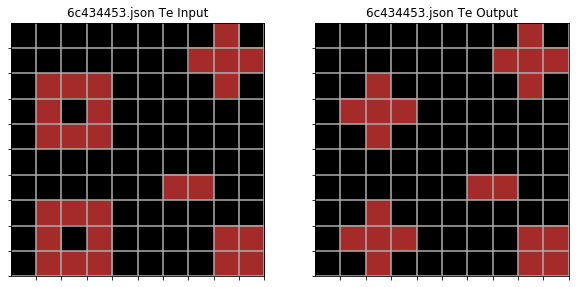

i = 41


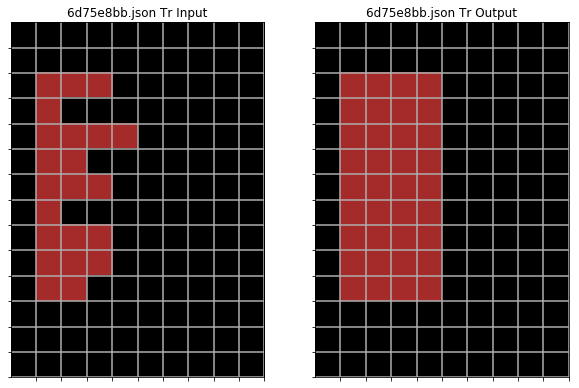

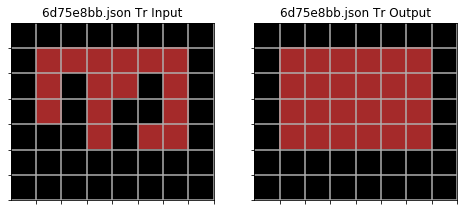

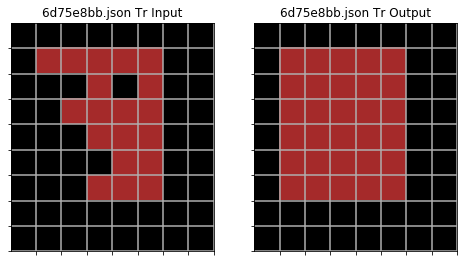

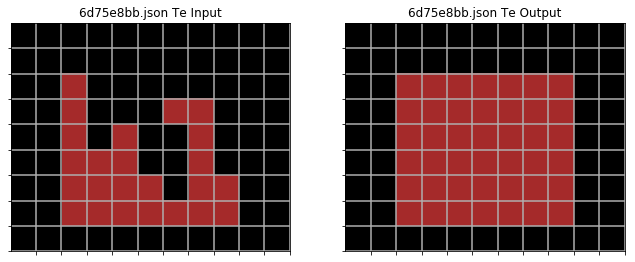

i = 46


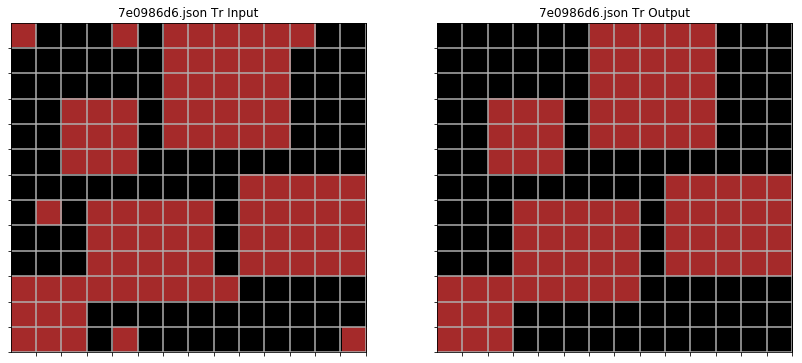

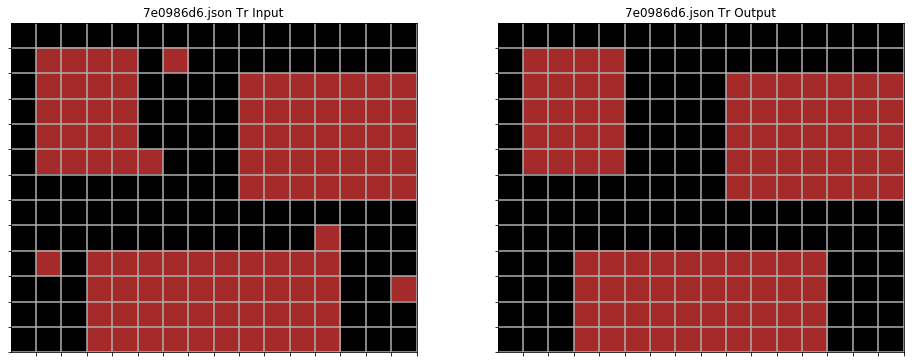

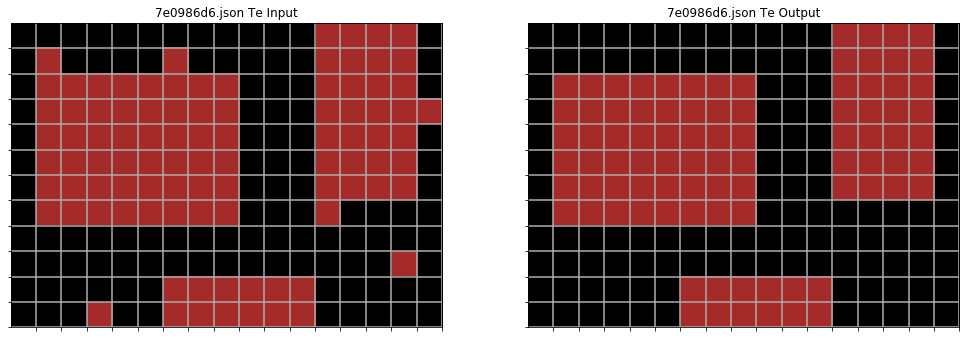

i = 47


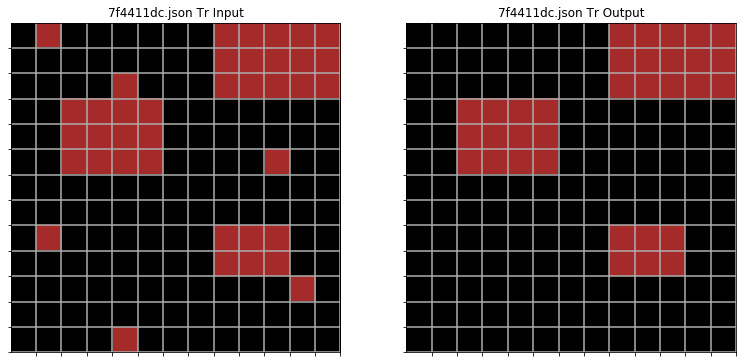

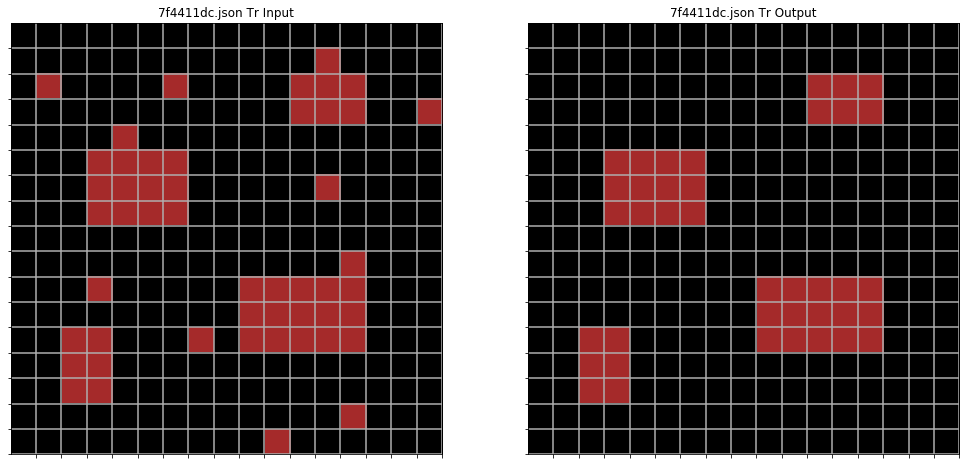

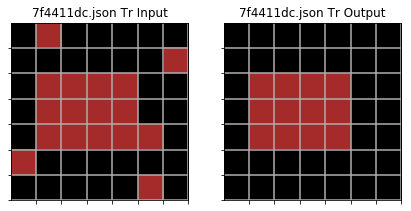

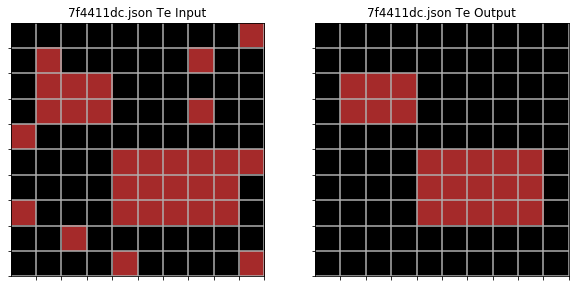

i = 48


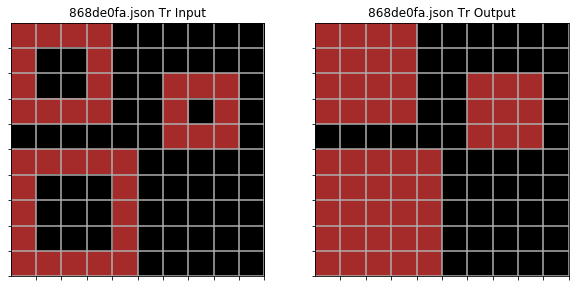

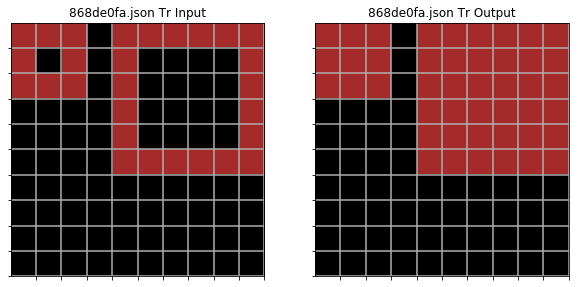

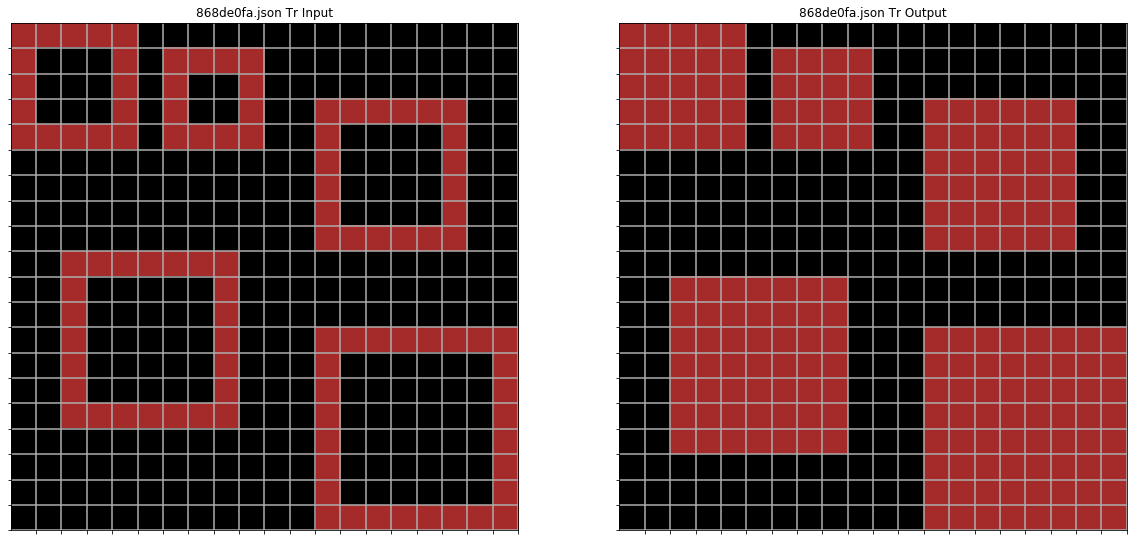

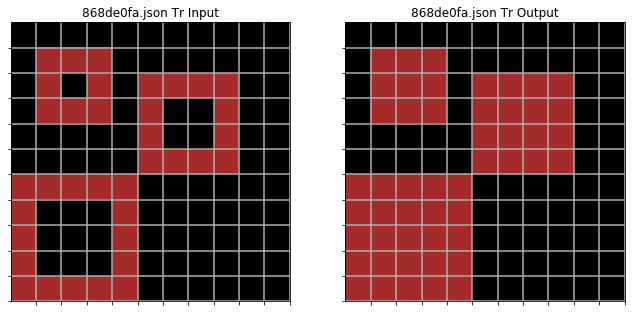

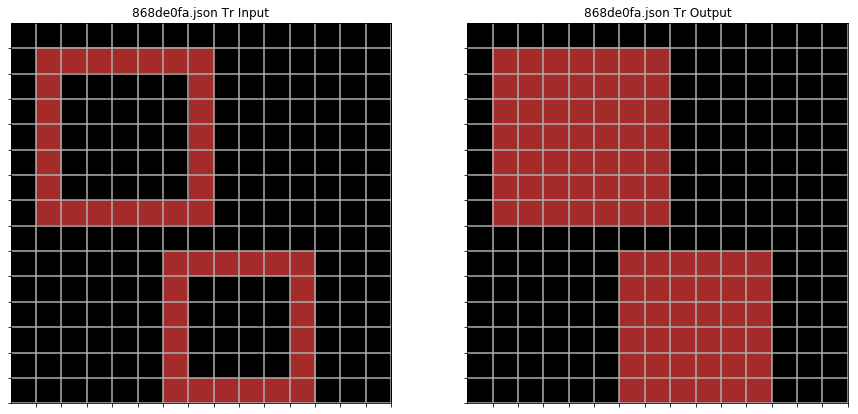

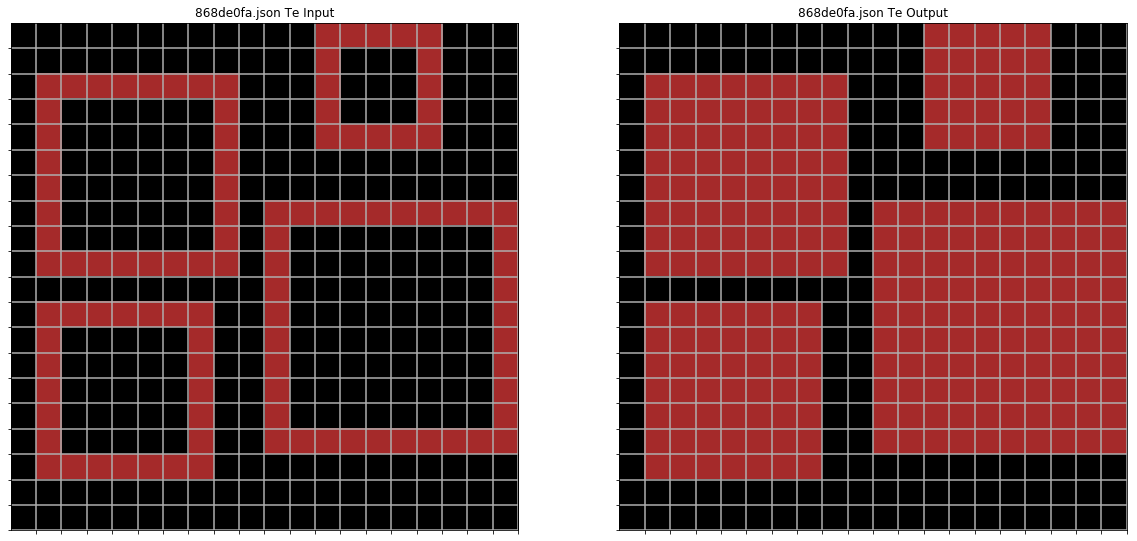

i = 52


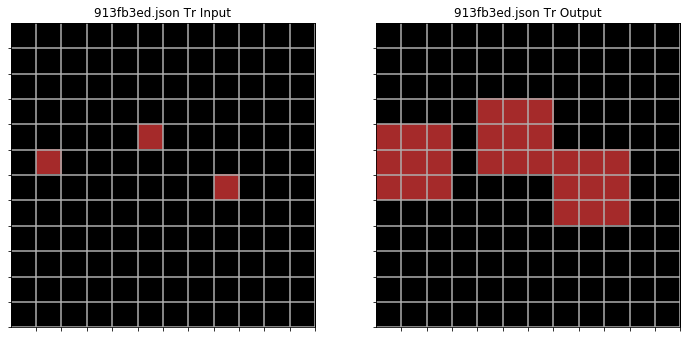

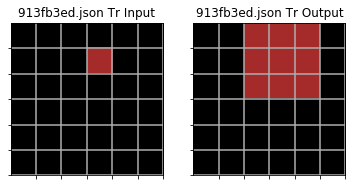

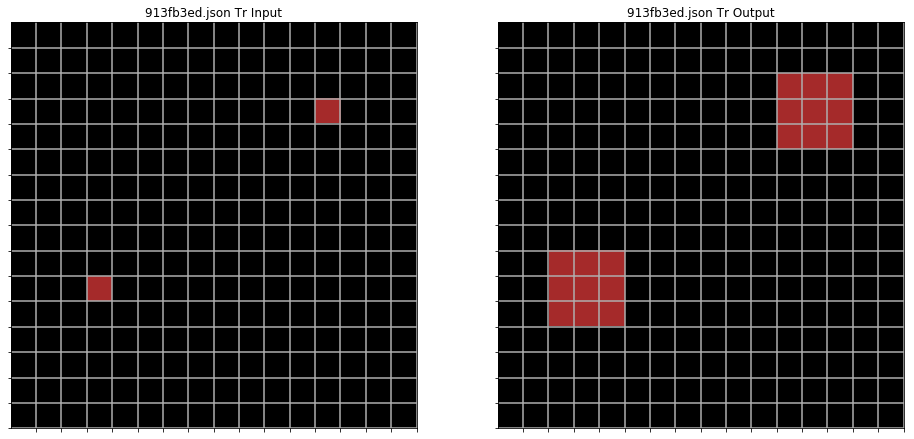

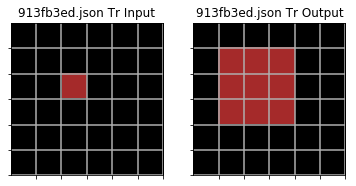

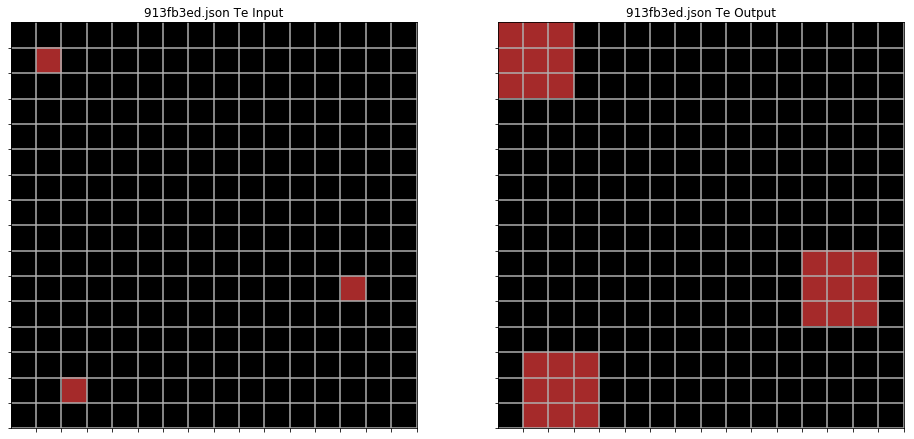

i = 54


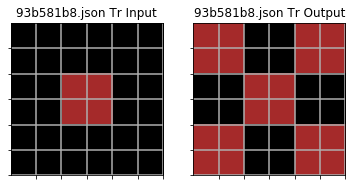

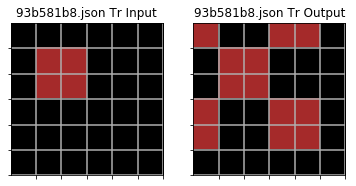

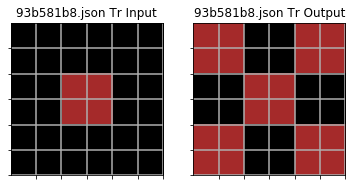

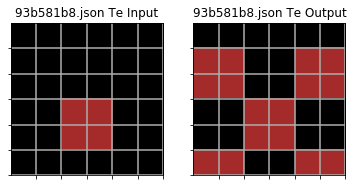

i = 55


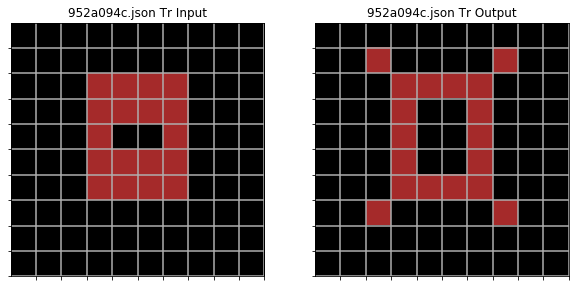

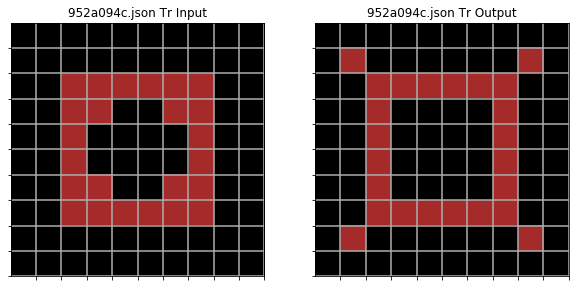

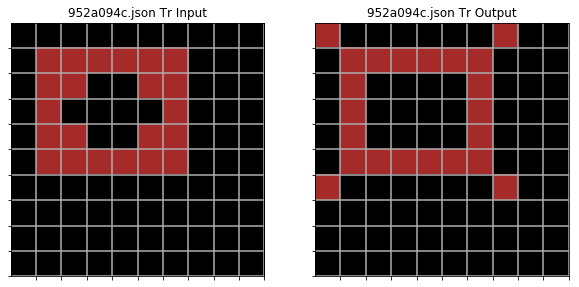

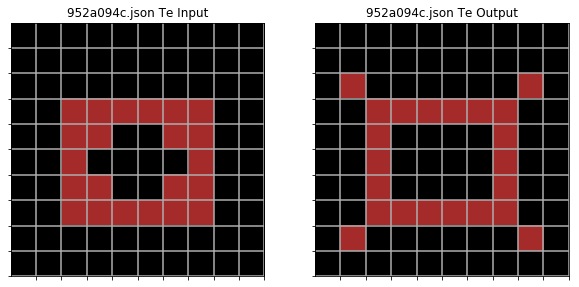

In [8]:
print('Visualizing files in substitution category mini training')
substitution_examples_train = [4, 19, 20, 21, 22, 23, 25, 26, 33, 36, 39, 40, 41, 46, 47, 48, 52, 54, 55]
for i in substitution_examples_train:
    print(f'i = {i}')
    filename = onlyfiles_train[i]
    train_list, test_list = read_single_training_example(filename)
    show_single_training_example_visually(train_list, test_list, filename, removeColorAsp=False, drawGridAroundObjects=False)

In [10]:
# print('Visualizing files in substitution category mini testing')
# substitution_examples_test = [0, 3, 11, 14, 20, 21, 23, 24, 27, 29, 31, 34, 36, 42]
# for i in substitution_examples_test:
#     print(f'i = {i}')
#     filename = onlyfiles_test[i]
#     train_list, test_list = read_single_training_example(filename)
#     show_single_training_example_visually(train_list, test_list, filename, removeColorAsp=False, drawGridAroundObjects=False)

In [71]:
class ARC_SUBSTITUTION1(nn.Module):
    
    def __init__(self, kernel_size, pad):
        super(ARC_SUBSTITUTION1, self).__init__()
        self.conv_1 = nn.Conv2d(1, 1, kernel_size, padding=pad)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = torch.sigmoid(x)
        return x

In [146]:
class TrainTestModel():
    
    def __init__(self, ON, OFF, B = None, kernel_size = 3, pad = 1, reduction='mean'):
        self.B = B
        self.ON = ON
        self.OFF = OFF
        self.kernel_size = kernel_size
        self.pad = pad
        self.reduction = reduction
        self.bce_loss = nn.BCELoss(reduction=self.reduction)
        #self.bce_loss = nn.BCELoss(reduction='none')
        self.decideModel()

    def augmentData(list_dicts, B, noAugment=False):
        #This will augment each pair B times
        ON, OFF = 9, 0
        aug_inputs = []
        aug_outputs = []
        aug_ONs = []
        aug_OFFs = []
        if (noAugment):
            print('Augmentation is OFF.')
            B = None
        for pair in list_dicts:
            augmented_pairs = {'input': [], 'output': [], 'ON': [], 'OFF': []}
            inp = np.array(pair['input'])
            op = np.array(pair['output'])
            assert np.logical_or(inp == ON, inp == OFF).all() == True, "It should have only 2 type of values"
            assert np.logical_or(op == ON, op == OFF).all() == True, "It should have only 2 type of values"
            count = 0
            for newOFF in np.arange(10):
                for newON in np.arange(10):
                    if (newON == newOFF):
                        continue
                    if (B is not None and count >= B):
                        continue
                    if (noAugment and (newOFF != OFF or newON != ON)):
                        #print(ON, OFF, newON, newOFF, newON != ON, newOFF != OFF, B, newOFF is not OFF or newON is not ON)
                        continue
                    newInp = np.zeros(inp.shape)
                    newInp[inp == ON] = newON
                    newInp[inp == OFF] = newOFF
                    newOp = np.zeros(op.shape)
                    newOp[op == ON] = newON
                    newOp[op == OFF] = newOFF
                    #We have a pair inp, op -> newIn, newOp
                    newInp = newInp.reshape((1, newInp.shape[0], newInp.shape[1]))
                    newOp = newOp.reshape((1, newOp.shape[0], newOp.shape[1]))
                    augmented_pairs['input'].append(newInp)
                    augmented_pairs['output'].append(newOp)
                    augmented_pairs['ON'].append(newON)
                    augmented_pairs['OFF'].append(newOFF)
                    count += 1
            augmented_pairs['input'] = np.array(augmented_pairs['input'])
            augmented_pairs['output'] = np.array(augmented_pairs['output'])
            augmented_pairs['ON'] = np.array(augmented_pairs['ON'])
            augmented_pairs['OFF'] = np.array(augmented_pairs['OFF'])
            aug_inputs.append(torch.from_numpy(augmented_pairs['input']).type(torch.float32))
            aug_outputs.append(torch.from_numpy(augmented_pairs['output']).type(torch.float32))
            aug_ONs.append(torch.from_numpy(augmented_pairs['ON']).type(torch.float32))
            aug_OFFs.append(torch.from_numpy(augmented_pairs['OFF']).type(torch.float32))
        return aug_inputs,\
               aug_outputs,\
               aug_ONs,\
               aug_OFFs
    
    def readData(self, filename, noAug=False):
        self.filename = filename
        self.train_list, self.test_list = read_single_training_example(filename)
        self.train_list_aug_input, self.train_list_aug_output, self.train_list_aug_ONs, self.train_list_aug_OFFs = \
            TrainTestModel.augmentData(self.train_list, self.B, noAugment=noAug) 
            
    def decideModel(self):
        self.model = ARC_SUBSTITUTION1(kernel_size = self.kernel_size, pad = self.pad) #Solved i = 25 in train
        #self.model = ARC_SUBSTITUTION1(kernel_size = 5, pad = 2) #Solved i = 25 in train
    
    def compute_loss(self, model_op, op_grid, ON):
        N, C, H, W = model_op.shape
        ON_flatten = ON.repeat(C*H*W)
        op_flatten = torch.flatten(op_grid)
        targets = torch.zeros(N*C*H*W, dtype=torch.float32)
        targets[ON_flatten == op_flatten] = 1
        loss = self.bce_loss(torch.flatten(model_op), targets)
        #loss = (self.bce_loss(torch.flatten(model_op), targets)) ** 2
        if (self.reduction == 'none'):
            loss = loss.mean()
        return loss       
    
    def train(self, epochs, print_every, test_every, learning_rate):
        self.model.train()
        numBatches = len(self.train_list_aug_input)
        #numBatches = 1
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        for i in np.arange(1, epochs+1):
            for b in np.arange(numBatches):
                Xtrain_ip_grids_tensor = self.train_list_aug_input[b]
                Xtrain_op_grids_tensor = self.train_list_aug_output[b]
                ONs = self.train_list_aug_ONs[b]
                OFFs = self.train_list_aug_OFFs[b]
                #print(Xtrain_ip_grids_tensor.shape, Xtrain_op_grids_tensor.shape, ONs.shape, OFFs.shape)
                ytrain_op_preds = self.model(Xtrain_ip_grids_tensor)
                #print(ytrain_op_preds.shape)
                loss = self.compute_loss(ytrain_op_preds, Xtrain_op_grids_tensor, ONs)
                if (i % print_every == 0):
                    print(f'epoch: {i}, batch_id: {b}, loss: {loss}')
                self.model.zero_grad()
                loss.backward()
                optimizer.step()    
                
                #Check our progress
                actual_ip_grid = np.array(self.train_list[b]['input'])
                actual_ip_grid = actual_ip_grid.reshape((1, 1, actual_ip_grid.shape[0], actual_ip_grid.shape[1]))
                actual_ip_grid = torch.from_numpy(actual_ip_grid).type(torch.float32)

                actual_op_grid = np.array(self.train_list[b]['output'])
                actual_op_grid = actual_op_grid.reshape((1, 1, actual_op_grid.shape[0], actual_op_grid.shape[1]))
                actual_op_grid = torch.from_numpy(actual_op_grid).type(torch.float32)

                ytrain_op_pred_grid = self.pred_output_grid(actual_ip_grid, self.ON, self.OFF)
                if (print_every is not None and i % print_every == 0):
                    TrainTestModel.compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_pred_grid, header = '[TRAIN]')
                if (test_every is not None and i % test_every == 0):
                    #print(self.model(actual_ip_grid))
                    show_single_training_example_visually([{'input': np.squeeze(actual_ip_grid.data.numpy()), 'output': np.squeeze(ytrain_op_pred_grid.data.numpy())}], [],\
                                                          self.filename, removeColorAsp=False, drawGridAroundObjects=False)
                
        return
    
    def pred_output_grid(self, x, ON, OFF):
        op = self.model(x)
        output_grid = torch.zeros(op.shape)
        output_grid[op >= 0.5] = ON
        output_grid[op < 0.5] = OFF
        return output_grid
    
    def compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_grid, header=''):
        diff_cells = actual_ip_grid != actual_op_grid
        corr_pred = actual_op_grid == ytrain_op_grid
        accuracyOfModel = np.logical_and(diff_cells, corr_pred)
        accuracy = (100.0 * accuracyOfModel.sum())/(diff_cells.sum())
        accuracy_overall = (100.0 * corr_pred.sum())/(corr_pred.numel())
        print(f'{header} {accuracyOfModel.sum()} elements matched out of {diff_cells.sum()} diff. elements.\
        Accuracy: {accuracy}. Overall Accuracy: {accuracy_overall}')
        return accuracy, accuracy_overall
    
    def test(self):
        for test_pair_input in self.train_list:
            actual_ip_grid = np.array(test_pair_input['input'])
            actual_ip_grid = actual_ip_grid.reshape((1, 1, actual_ip_grid.shape[0], actual_ip_grid.shape[1]))
            actual_ip_grid = torch.from_numpy(actual_ip_grid).type(torch.float32)

            actual_op_grid = np.array(test_pair_input['output'])
            actual_op_grid = actual_op_grid.reshape((1, 1, actual_op_grid.shape[0], actual_op_grid.shape[1]))
            actual_op_grid = torch.from_numpy(actual_op_grid).type(torch.float32)

            ytrain_op_pred_grid = self.pred_output_grid(actual_ip_grid, self.ON, self.OFF)
            print('actual ip grid', actual_ip_grid)
            print('actual op grid', actual_op_grid)
            print('pred   op grid', ytrain_op_pred_grid)
            accuracy, accuracy_overall = TrainTestModel.compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_pred_grid, header = '[TEST]')
            print('Training Data')
            show_single_training_example_visually(self.train_list, [], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Expected Output')
            show_single_training_example_visually([], self.test_list, self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Actual Output')
            show_single_training_example_visually([], [{'input': np.squeeze(actual_ip_grid.data.numpy()), 'output': np.squeeze(ytrain_op_pred_grid.data.numpy())}], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            if (accuracy_overall == 100.0):
                print('Task successfully solved.')
            else:
                print('NN not able to solve the task')
        for test_pair_input in self.test_list:
            actual_ip_grid = np.array(test_pair_input['input'])
            actual_ip_grid = actual_ip_grid.reshape((1, 1, actual_ip_grid.shape[0], actual_ip_grid.shape[1]))
            actual_ip_grid = torch.from_numpy(actual_ip_grid).type(torch.float32)

            actual_op_grid = np.array(test_pair_input['output'])
            actual_op_grid = actual_op_grid.reshape((1, 1, actual_op_grid.shape[0], actual_op_grid.shape[1]))
            actual_op_grid = torch.from_numpy(actual_op_grid).type(torch.float32)

            ytrain_op_pred_grid = self.pred_output_grid(actual_ip_grid, self.ON, self.OFF)
            print('actual ip grid', actual_ip_grid)
            print('actual op grid', actual_op_grid)
            print('pred   op grid', ytrain_op_pred_grid)
            accuracy, accuracy_overall = TrainTestModel.compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_pred_grid, header = '[TEST]')
            print('Training Data')
            show_single_training_example_visually(self.train_list, [], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Expected Output')
            show_single_training_example_visually([], self.test_list, self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Actual Output')
            show_single_training_example_visually([], [{'input': np.squeeze(actual_ip_grid.data.numpy()), 'output': np.squeeze(ytrain_op_pred_grid.data.numpy())}], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            if (accuracy_overall == 100.0):
                print('Task successfully solved.')
            else:
                print('NN not able to solve the task')
            
 
# i = 25
# ttm = TrainTestModel(ON=9, OFF=0, B = 1)
# ttm.readData(onlyfiles_train[i])
# ttm.train(1000)
# ttm.test()

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 1.0532900094985962
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 69.44444274902344
epoch: 1, batch_id: 1, loss: 1.0413086414337158
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 68.75
epoch: 2, batch_id: 0, loss: 1.0142567157745361
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 69.44444274902344
epoch: 2, batch_id: 1, loss: 1.0034430027008057
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 68.75
epoch: 3, batch_id: 0, loss: 0.9777672290802002
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 69.44444274902344
epoch: 3, batch_id: 1, loss: 0.9680984020233154
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. O

epoch: 35, batch_id: 1, loss: 0.5389144420623779
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 85.41666412353516
epoch: 36, batch_id: 0, loss: 0.5353102087974548
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 36, batch_id: 1, loss: 0.534163773059845
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 85.41666412353516
epoch: 37, batch_id: 0, loss: 0.5308021306991577
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 37, batch_id: 1, loss: 0.529589056968689
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.80555725097656
epoch: 38, batch_id: 0, loss: 0.5264584422111511
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.80555725097656
epoch: 38, batch_id: 1, loss: 

epoch: 72, batch_id: 0, loss: 0.43271690607070923
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 72, batch_id: 1, loss: 0.43008407950401306
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 73, batch_id: 0, loss: 0.430843710899353
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 73, batch_id: 1, loss: 0.42819565534591675
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 74, batch_id: 0, loss: 0.42899829149246216
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 74, batch_id: 1, loss: 0.42633622884750366
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 6

[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 93.05555725097656
epoch: 116, batch_id: 0, loss: 0.36901021003723145
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.66666412353516
epoch: 116, batch_id: 1, loss: 0.3662766218185425
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 93.05555725097656
epoch: 117, batch_id: 0, loss: 0.3678700625896454
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.66666412353516
epoch: 117, batch_id: 1, loss: 0.365141361951828
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 93.05555725097656
epoch: 118, batch_id: 0, loss: 0.36673876643180847
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.66666412

[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 156, batch_id: 1, loss: 0.3270324468612671
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 157, batch_id: 0, loss: 0.3286326229572296
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 157, batch_id: 1, loss: 0.326183557510376
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 158, batch_id: 0, loss: 0.32778069376945496
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 158, batch_id: 1, loss: 0.325339674949646
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 159, batch_id: 0, loss: 0.326934278011322
[TRAIN] 18 elements matc

[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 198, batch_id: 0, loss: 0.2974100112915039
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 198, batch_id: 1, loss: 0.29528647661209106
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 199, batch_id: 0, loss: 0.2967304587364197
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 199, batch_id: 1, loss: 0.2946144938468933
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 200, batch_id: 0, loss: 0.29605424404144287
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 200, batch_id: 1, loss: 0.29394614696502686
[TRAIN] 18 elements

epoch: 236, batch_id: 1, loss: 0.27189871668815613
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 237, batch_id: 0, loss: 0.2731729745864868
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 237, batch_id: 1, loss: 0.27133679389953613
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 238, batch_id: 0, loss: 0.2726063132286072
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 238, batch_id: 1, loss: 0.2707774043083191
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 239, batch_id: 0, loss: 0.2720421552658081
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 239, batch_id

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 277, batch_id: 0, loss: 0.25227805972099304
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 277, batch_id: 1, loss: 0.25070255994796753
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 278, batch_id: 0, loss: 0.25179818272590637
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 278, batch_id: 1, loss: 0.2502289116382599
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 279, batch_id: 0, loss: 0.2513200640678406
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 279, batch_id: 1, loss: 0.2497565746307373
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 317, batch_id: 1, loss: 0.2330912947654724
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 318, batch_id: 0, loss: 0.23402850329875946
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 318, batch_id: 1, loss: 0.23268373310565948
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 319, batch_id: 0, loss: 0.23361730575561523
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 319, batch_id: 1, loss: 0.23227760195732117
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 320, batch_id: 0, loss: 0.23320725560188293
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 359, batch_id: 1, loss: 0.2171488106250763
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 360, batch_id: 0, loss: 0.2179405838251114
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 360, batch_id: 1, loss: 0.21679671108722687
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 0, loss: 0.21758517622947693
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 1, loss: 0.21644553542137146
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 0, loss: 0.2172309011220932
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall

epoch: 400, batch_id: 1, loss: 0.20360782742500305
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 0, loss: 0.2042778730392456
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 1, loss: 0.2032993584871292
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 0, loss: 0.20396654307842255
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 1, loss: 0.2029915452003479
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 0, loss: 0.2036558836698532
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 1, loss: 0.20268484950065613
[TRAIN] 24 elements matched out of 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 439, batch_id: 1, loss: 0.19224557280540466
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 440, batch_id: 0, loss: 0.19281665980815887
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 440, batch_id: 1, loss: 0.1919715255498886
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 441, batch_id: 0, loss: 0.19253984093666077
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 441, batch_id: 1, loss: 0.19169823825359344
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 442, batch_id: 0, loss: 0.19226449728012085
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 481, batch_id: 1, loss: 0.181385338306427
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 0, loss: 0.18186625838279724
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 1, loss: 0.1811423897743225
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 483, batch_id: 0, loss: 0.18162128329277039
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 483, batch_id: 1, loss: 0.18089982867240906
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 484, batch_id: 0, loss: 0.1813766360282898
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall 

epoch: 524, batch_id: 0, loss: 0.17212945222854614
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 524, batch_id: 1, loss: 0.17150633037090302
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 525, batch_id: 0, loss: 0.17191074788570404
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 525, batch_id: 1, loss: 0.17128998041152954
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 526, batch_id: 0, loss: 0.1716928482055664
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 526, batch_id: 1, loss: 0.17107391357421875
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 527, batch_id: 0, loss: 0.17147499322891235
[TRAIN] 24 elements matched out 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 568, batch_id: 0, loss: 0.16302573680877686
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 568, batch_id: 1, loss: 0.16249018907546997
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 569, batch_id: 0, loss: 0.16283032298088074
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 569, batch_id: 1, loss: 0.1622968316078186
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 570, batch_id: 0, loss: 0.16263550519943237
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 570, batch_id: 1, loss: 0.1621037870645523
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 611, batch_id: 1, loss: 0.15458492934703827
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 0, loss: 0.1548738330602646
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 1, loss: 0.15441058576107025
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 613, batch_id: 0, loss: 0.15469832718372345
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 613, batch_id: 1, loss: 0.15423673391342163
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 614, batch_id: 0, loss: 0.15452341735363007
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 653, batch_id: 1, loss: 0.14760349690914154
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 654, batch_id: 0, loss: 0.14785176515579224
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 654, batch_id: 1, loss: 0.14744538068771362
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 655, batch_id: 0, loss: 0.14769259095191956
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 655, batch_id: 1, loss: 0.14728747308254242
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 656, batch_id: 0, loss: 0.14753404259681702
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 1, loss: 0.1411101073026657
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 0, loss: 0.14132481813430786
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 1, loss: 0.14096640050411224
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 698, batch_id: 0, loss: 0.14118029177188873
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 698, batch_id: 1, loss: 0.14082275331020355
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 699, batch_id: 0, loss: 0.1410360187292099
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 1, loss: 0.13506074249744415
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 0, loss: 0.13524839282035828
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 1, loss: 0.1349295824766159
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 742, batch_id: 0, loss: 0.1351165622472763
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 742, batch_id: 1, loss: 0.13479864597320557
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 743, batch_id: 0, loss: 0.13498519361019135
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 0, loss: 0.12982311844825745
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 1, loss: 0.1295360028743744
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 785, batch_id: 0, loss: 0.12970252335071564
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 785, batch_id: 1, loss: 0.1294160634279251
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 0, loss: 0.12958206236362457
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 1, loss: 0.12929625809192657
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 827, batch_id: 0, loss: 0.12484310567378998
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 827, batch_id: 1, loss: 0.12458118051290512
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 828, batch_id: 0, loss: 0.12473195046186447
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 828, batch_id: 1, loss: 0.12447064369916916
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 829, batch_id: 0, loss: 0.12462125718593597
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 829, batch_id: 1, loss: 0.12436045706272125
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 869, batch_id: 1, loss: 0.12011592835187912
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 0, loss: 0.12025543302297592
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 1, loss: 0.12001368403434753
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 871, batch_id: 0, loss: 0.12015310674905777
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 871, batch_id: 1, loss: 0.1199118047952652
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 872, batch_id: 0, loss: 0.12005089223384857
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 914, batch_id: 1, loss: 0.11569556593894958
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 915, batch_id: 0, loss: 0.11582662165164948
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 915, batch_id: 1, loss: 0.11560123413801193
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 916, batch_id: 0, loss: 0.11573226004838943
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 916, batch_id: 1, loss: 0.11550720781087875
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 917, batch_id: 0, loss: 0.11563796550035477
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

epoch: 958, batch_id: 0, loss: 0.11191096901893616
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 1, loss: 0.11169738322496414
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 0, loss: 0.11182316392660141
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 1, loss: 0.11160998791456223
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 960, batch_id: 0, loss: 0.11173568665981293
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 960, batch_id: 1, loss: 0.11152258515357971
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 961, batch_id: 0, loss: 0.1116483062505722
[TRAIN] 24 elements matched out 

actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 0., 9., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 0., 9., 0., 9., 0., 9., 0., 9., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 0., 9., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 0., 9., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
       

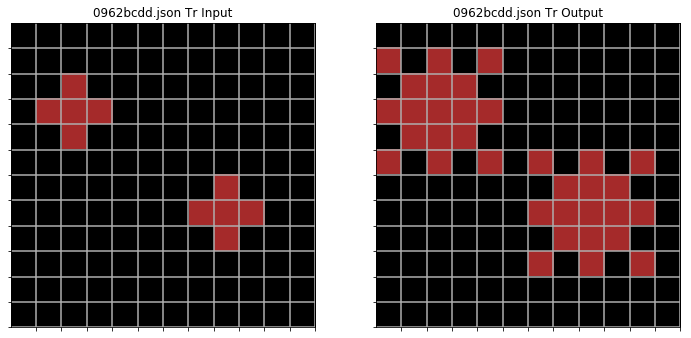

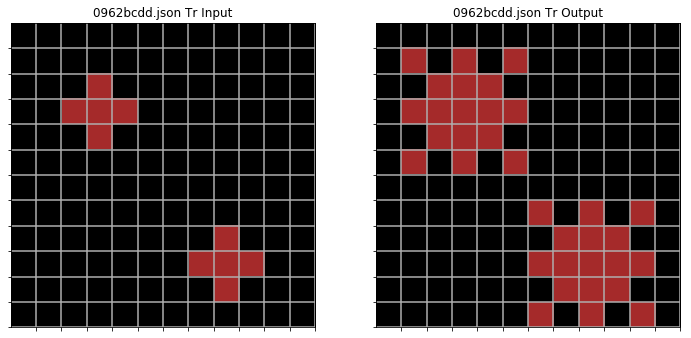

Expected Output


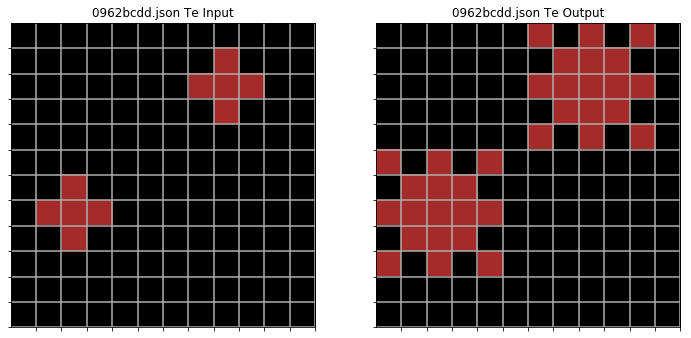

Actual Output


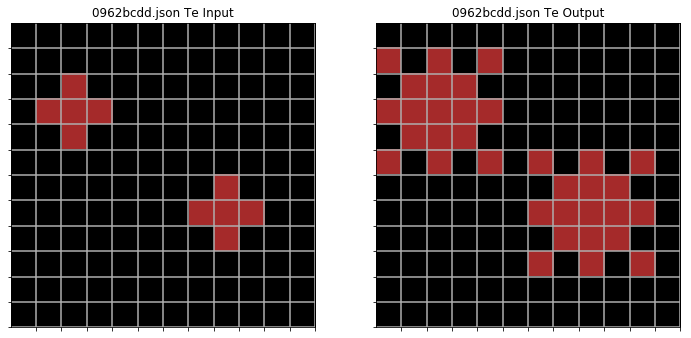

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 9., 0., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 0., 0.

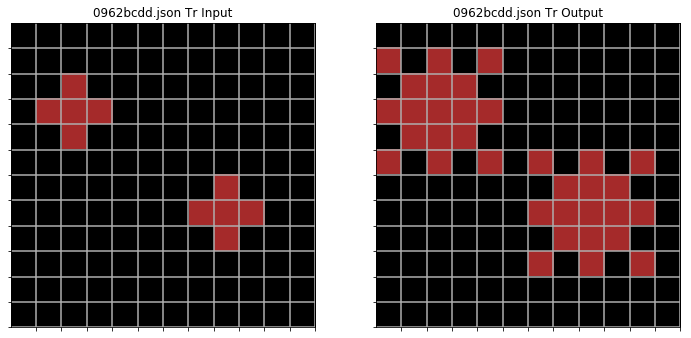

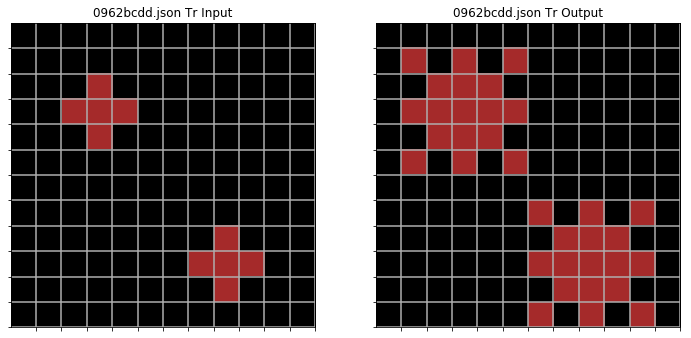

Expected Output


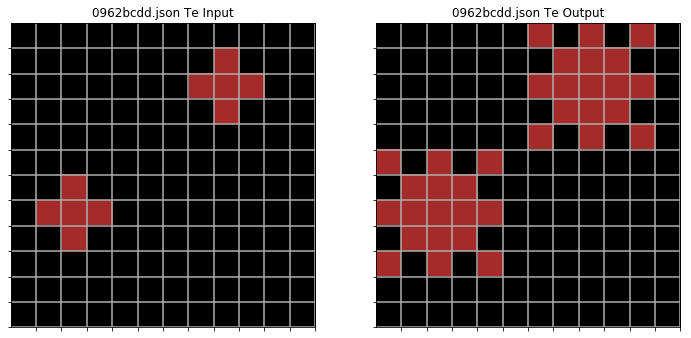

Actual Output


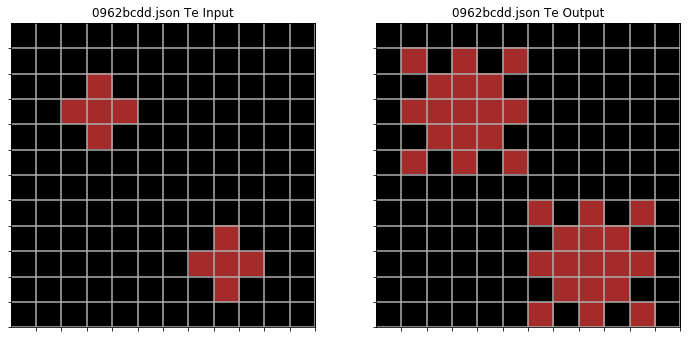

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 9., 0., 9., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9.

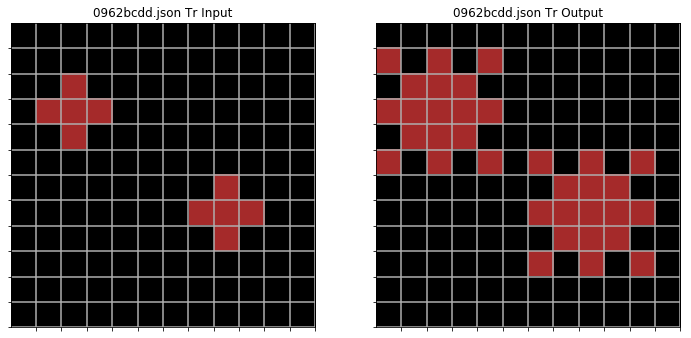

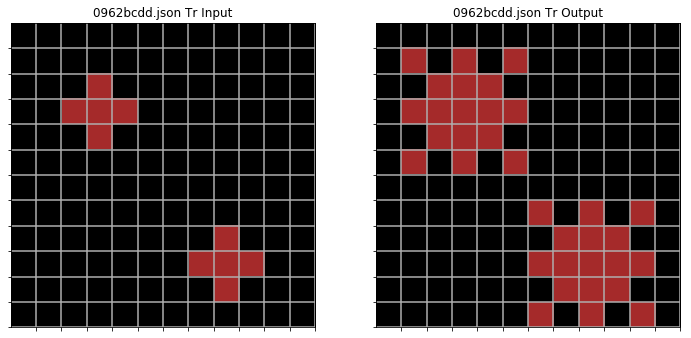

Expected Output


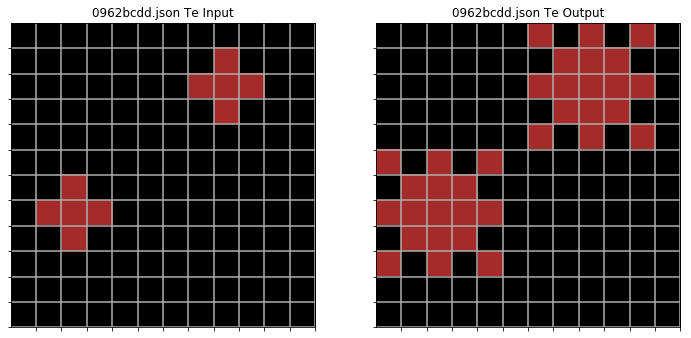

Actual Output


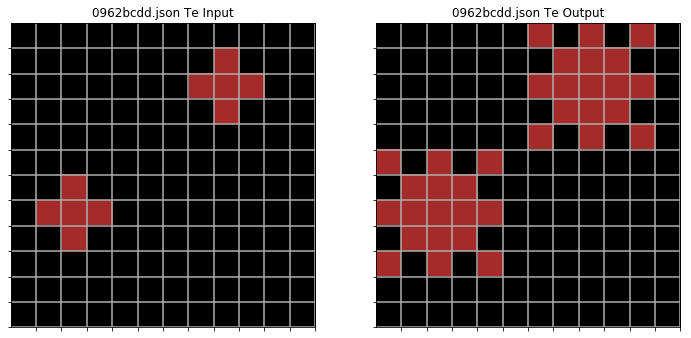

Task successfully solved.


In [148]:
i = 4
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=5,pad=2, reduction='mean')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: simple mean bce (no squaring)
#Status: Succesfully solved

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.7445052862167358
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 81.48148345947266
epoch: 1, batch_id: 1, loss: 0.7812961339950562
[TRAIN] 12 elements matched out of 32 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.30863952636719
epoch: 2, batch_id: 0, loss: 0.7359575629234314
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 81.48148345947266
epoch: 2, batch_id: 1, loss: 0.7702404260635376
[TRAIN] 12 elements matched out of 32 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.30863952636719
epoch: 3, batch_id: 0, loss: 0.7275826930999756
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 81.48148345947266
epoch: 3, batch_id: 1, loss: 0.7594190239906311
[TRAIN] 12 elements matched out of 32 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.30863952636719
epoch: 4, batch_

epoch: 41, batch_id: 0, loss: 0.517879843711853
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.29629516601562
epoch: 41, batch_id: 1, loss: 0.49605128169059753
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 95.06172943115234
epoch: 42, batch_id: 0, loss: 0.5145233273506165
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.29629516601562
epoch: 42, batch_id: 1, loss: 0.49205291271209717
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 95.06172943115234
epoch: 43, batch_id: 0, loss: 0.5112402439117432
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.29629516601562
epoch: 43, batch_id: 1, loss: 0.488153338432312
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 95.06172943115234
epoch: 44, batch_id: 0, loss

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 1, loss: 0.3879278898239136
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 0, loss: 0.42050227522850037
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 1, loss: 0.38609015941619873
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 83, batch_id: 0, loss: 0.41878414154052734
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 83, batch_id: 1, loss: 0.38427847623825073
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 84, batch_id: 0, loss: 0.41708505153656006
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Acc

epoch: 123, batch_id: 1, loss: 0.326620876789093
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 124, batch_id: 0, loss: 0.3606168031692505
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 124, batch_id: 1, loss: 0.3254470229148865
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 125, batch_id: 0, loss: 0.3594207763671875
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 125, batch_id: 1, loss: 0.32428252696990967
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 126, batch_id: 0, loss: 0.3582328259944916
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 126, batch_id: 1, loss: 0.3231273591518402
[TRAIN] 32 elements matched out of 32 

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 0, loss: 0.3181644380092621
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 1, loss: 0.28495678305625916
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 165, batch_id: 0, loss: 0.31722405552864075
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 165, batch_id: 1, loss: 0.28407707810401917
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 166, batch_id: 0, loss: 0.3162889778614044
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 166, batch_id: 1, loss: 0.2832026183605194
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 0, loss: 0.28957802057266235
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 1, loss: 0.2584645450115204
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 0, loss: 0.28878331184387207
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 1, loss: 0.25773492455482483
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 199, batch_id: 0, loss: 0.2879926860332489
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 199, batch_id: 1, loss: 0.25700923800468445
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

epoch: 227, batch_id: 0, loss: 0.267305463552475
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 227, batch_id: 1, loss: 0.23812678456306458
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 228, batch_id: 0, loss: 0.26661473512649536
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 228, batch_id: 1, loss: 0.23749971389770508
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 229, batch_id: 0, loss: 0.26592761278152466
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 229, batch_id: 1, loss: 0.23687565326690674
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 230, batch_id: 0, loss: 0.2652432322502136
[TRAIN] 24 elements matched out of

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 0, loss: 0.24847395718097687
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 1, loss: 0.2210880070924759
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 257, batch_id: 0, loss: 0.24786607921123505
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 257, batch_id: 1, loss: 0.22053998708724976
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 258, batch_id: 0, loss: 0.24726079404354095
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 258, batch_id: 1, loss: 0.21999448537826538
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overa

epoch: 282, batch_id: 1, loss: 0.2075960785150528
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 0, loss: 0.23292779922485352
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 1, loss: 0.2071067839860916
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 0, loss: 0.23238471150398254
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 1, loss: 0.20661967992782593
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 285, batch_id: 0, loss: 0.23184385895729065
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 285, batch_id: 1, loss: 0.20613446831703186
[TRAIN] 32 elements matched out o

epoch: 320, batch_id: 0, loss: 0.21421903371810913
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 320, batch_id: 1, loss: 0.19036200642585754
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 321, batch_id: 0, loss: 0.2137502282857895
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 321, batch_id: 1, loss: 0.18994317948818207
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 0, loss: 0.21328333020210266
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 1, loss: 0.1895262748003006
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 323, batch_id: 0, loss: 0.21281810104846954
[TRAIN] 24 elements matched out o

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 1, loss: 0.17446190118789673
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 0, loss: 0.19598136842250824
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 1, loss: 0.17410415410995483
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 363, batch_id: 0, loss: 0.19558098912239075
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 363, batch_id: 1, loss: 0.17374759912490845
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 364, batch_id: 0, loss: 0.19518177211284637
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

epoch: 412, batch_id: 1, loss: 0.15776856243610382
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 413, batch_id: 0, loss: 0.1772671341896057
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 413, batch_id: 1, loss: 0.1574704498052597
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 414, batch_id: 0, loss: 0.1769321858882904
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 414, batch_id: 1, loss: 0.15717311203479767
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 415, batch_id: 0, loss: 0.17659851908683777
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 415, batch_id: 1, loss: 0.15687699615955353
[TRAIN] 32 elements matched out of

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 463, batch_id: 1, loss: 0.14376592636108398
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 464, batch_id: 0, loss: 0.16153447329998016
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 464, batch_id: 1, loss: 0.14351406693458557
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 0, loss: 0.1612512618303299
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 1, loss: 0.14326316118240356
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 466, batch_id: 0, loss: 0.16096913814544678
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

epoch: 498, batch_id: 0, loss: 0.15238869190216064
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 498, batch_id: 1, loss: 0.13540856540203094
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 499, batch_id: 0, loss: 0.1521340161561966
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 499, batch_id: 1, loss: 0.13518290221691132
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 500, batch_id: 0, loss: 0.15187996625900269
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 500, batch_id: 1, loss: 0.13495799899101257
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 501, batch_id: 0, loss: 0.15162687003612518
[TRAIN] 24 elements matched out 

epoch: 538, batch_id: 1, loss: 0.12689152359962463
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 0, loss: 0.14254775643348694
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 1, loss: 0.12669123709201813
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 0, loss: 0.14232221245765686
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 1, loss: 0.12649157643318176
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 541, batch_id: 0, loss: 0.1420975923538208
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 541, batch_id: 1, loss: 0.12629251182079315
[TRAIN] 32 elements matched out 

epoch: 578, batch_id: 0, loss: 0.13421550393104553
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 578, batch_id: 1, loss: 0.1193125918507576
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 0, loss: 0.1340138167142868
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 1, loss: 0.11913388222455978
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 580, batch_id: 0, loss: 0.13381251692771912
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 580, batch_id: 1, loss: 0.11895561218261719
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 581, batch_id: 0, loss: 0.13361181318759918
[TRAIN] 24 elements matched out o

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 616, batch_id: 0, loss: 0.1269209086894989
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 616, batch_id: 1, loss: 0.11285335570573807
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 617, batch_id: 0, loss: 0.12673886120319366
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 617, batch_id: 1, loss: 0.1126922070980072
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 618, batch_id: 0, loss: 0.12655724585056305
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 618, batch_id: 1, loss: 0.11253143846988678
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

epoch: 656, batch_id: 1, loss: 0.10672365874052048
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 657, batch_id: 0, loss: 0.11983413249254227
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 657, batch_id: 1, loss: 0.10657842457294464
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 0, loss: 0.11967046558856964
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 1, loss: 0.10643351823091507
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 0, loss: 0.11950735747814178
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 1, loss: 0.10628897696733475
[TRAIN] 32 elements matched out

epoch: 694, batch_id: 1, loss: 0.1014513447880745
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 695, batch_id: 0, loss: 0.11389513313770294
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 695, batch_id: 1, loss: 0.10131918638944626
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 0, loss: 0.1137462630867958
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 1, loss: 0.10118740797042847
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 0, loss: 0.11359774321317673
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 1, loss: 0.10105589032173157
[TRAIN] 32 elements matched out o

epoch: 736, batch_id: 0, loss: 0.10807595402002335
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 736, batch_id: 1, loss: 0.0961655005812645
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 0, loss: 0.10794100165367126
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 1, loss: 0.09604587405920029
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 0, loss: 0.10780636966228485
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 1, loss: 0.09592660516500473
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 0, loss: 0.10767190158367157
[TRAIN] 24 elements matched out 

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 778, batch_id: 0, loss: 0.10266706347465515
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 778, batch_id: 1, loss: 0.09137424826622009
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 779, batch_id: 0, loss: 0.10254452377557755
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 779, batch_id: 1, loss: 0.09126561135053635
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 780, batch_id: 0, loss: 0.10242225229740143
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 780, batch_id: 1, loss: 0.09115725755691528
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Over

epoch: 816, batch_id: 1, loss: 0.08741200715303421
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 817, batch_id: 0, loss: 0.0980822741985321
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 817, batch_id: 1, loss: 0.08731209486722946
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 818, batch_id: 0, loss: 0.09796992689371109
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 818, batch_id: 1, loss: 0.08721248805522919
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 819, batch_id: 0, loss: 0.0978575274348259
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 819, batch_id: 1, loss: 0.08711300045251846
[TRAIN] 32 elements matched out o

epoch: 858, batch_id: 1, loss: 0.08339476585388184
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 859, batch_id: 0, loss: 0.09355882555246353
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 859, batch_id: 1, loss: 0.08330336958169937
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 860, batch_id: 0, loss: 0.09345591813325882
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 860, batch_id: 1, loss: 0.0832122191786766
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 861, batch_id: 0, loss: 0.09335321187973022
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 861, batch_id: 1, loss: 0.08312119543552399
[TRAIN] 32 elements matched out 

epoch: 899, batch_id: 0, loss: 0.08960356563329697
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 899, batch_id: 1, loss: 0.07979750633239746
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 0, loss: 0.0895087718963623
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 1, loss: 0.07971341907978058
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 0, loss: 0.08941418677568436
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 1, loss: 0.0796295627951622
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 0, loss: 0.08931975066661835
[TRAIN] 24 elements matched out o

epoch: 940, batch_id: 1, loss: 0.0764835998415947
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 941, batch_id: 0, loss: 0.08577853441238403
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 941, batch_id: 1, loss: 0.07640601694583893
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 942, batch_id: 0, loss: 0.0856911838054657
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 942, batch_id: 1, loss: 0.07632865756750107
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 943, batch_id: 0, loss: 0.08560412377119064
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 943, batch_id: 1, loss: 0.07625139504671097
[TRAIN] 32 elements matched out o

epoch: 982, batch_id: 0, loss: 0.08233289420604706
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 982, batch_id: 1, loss: 0.07335032522678375
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 983, batch_id: 0, loss: 0.08225221931934357
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 983, batch_id: 1, loss: 0.0732787474989891
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 984, batch_id: 0, loss: 0.08217160403728485
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 984, batch_id: 1, loss: 0.07320722192525864
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 985, batch_id: 0, loss: 0.08209121972322464
[TRAIN] 24 elements matched out 

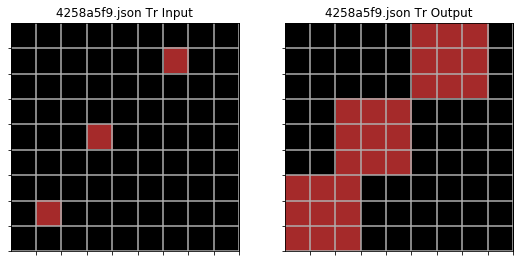

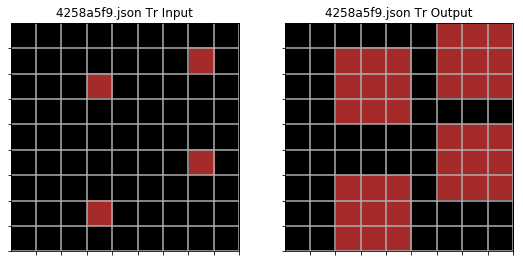

Expected Output


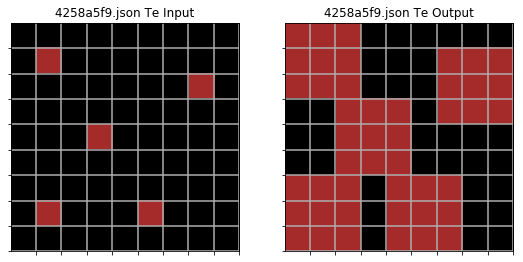

Actual Output


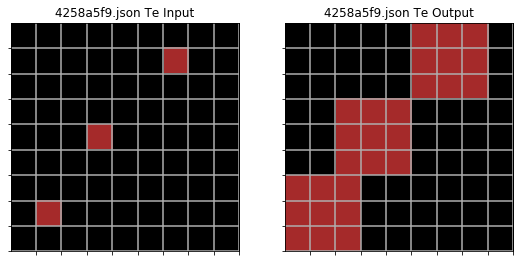

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [

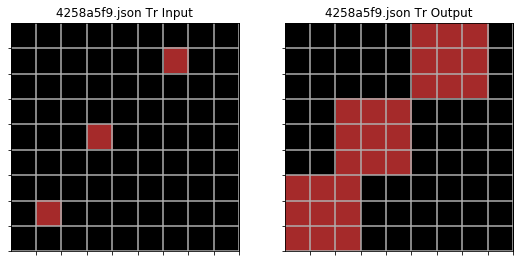

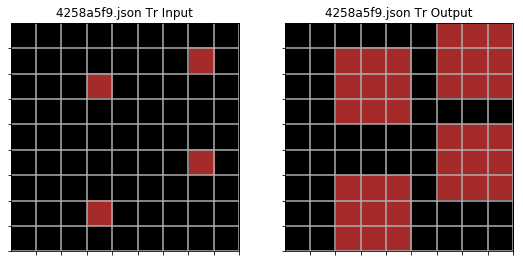

Expected Output


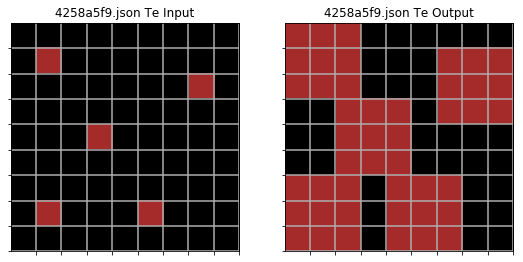

Actual Output


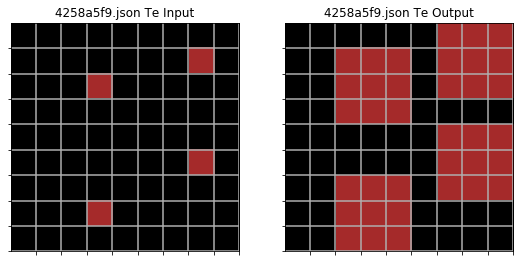

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 9., 9., 9.],
          [9., 9., 9., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [9., 9., 9., 0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 0., 9., 9., 9., 0., 0.]]]])
pred   op grid tensor([[[[9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [

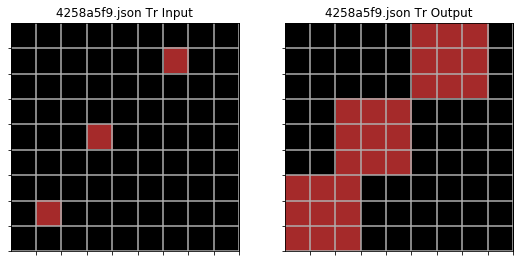

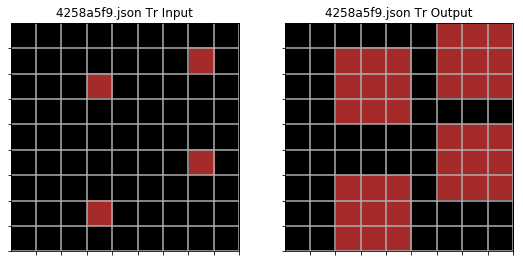

Expected Output


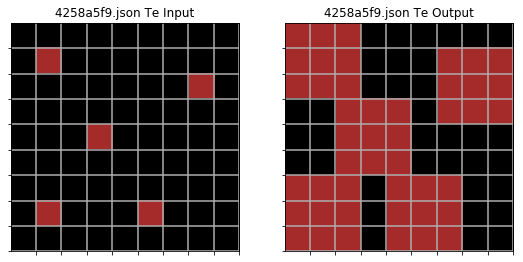

Actual Output


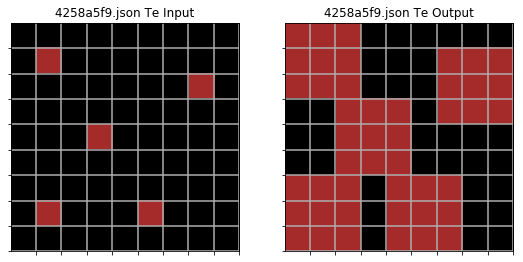

Task successfully solved.


In [149]:
i = 25
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3, pad=1, reduction='mean')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: simple mean bce (no squaring)
#Status: Succesfully solved

In [103]:
newOFF = 0
newON = 9
ON = 9
OFF = 0
print(True and (newOFF is not OFF or newON is not ON))

False


In [128]:
# m = nn.Sigmoid()
# loss = nn.BCELoss(reduction='mean')
# input = torch.randn(3, requires_grad=True)
# print(input)
# target = torch.empty(3).random_(2)
# print(target)
# a = m(input)
# print(a)
# output = loss(a, target)
# print(output)
# output.backward()
# print(input.grad)

Challenges faced by Neural Nets
1. Precision of output

NameError: name 'dfd' is not defined